# Classification on the Walmart Dataset

Task: load the Walmart dataset, write a Support Vector Machine to perform classification over the Month or Season in which a purchase was made, test the network and plot the results for each class.


## Importing libraries

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
%matplotlib inline

## Importing the Dataset

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?id=1p8oxgCFTktK8AJVc88JXq0kl4FWzuC9d&export=download' -O Walmart.csv

--2025-06-02 15:33:56--  https://drive.google.com/uc?id=1p8oxgCFTktK8AJVc88JXq0kl4FWzuC9d&export=download
Resolving drive.google.com (drive.google.com)... 142.250.141.101, 142.250.141.139, 142.250.141.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1p8oxgCFTktK8AJVc88JXq0kl4FWzuC9d&export=download [following]
--2025-06-02 15:33:56--  https://drive.usercontent.google.com/download?id=1p8oxgCFTktK8AJVc88JXq0kl4FWzuC9d&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 363732 (355K) [application/octet-stream]
Saving to: ‘Walmart.csv’

Walmart.csv         100%[===================>] 355.21K  --.-KB/s

In [ ]:
df = pd.read_csv("Walmart.csv")

## Exploring the data

In [ ]:
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

## Preparing the Data

Adding month and season from the Date column

In [ ]:
# Converting 'Date' in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

df['Year'] = df['Date'].dt.year

# Extracting the month as a number
df['Month'] = df['Date'].dt.month - 1 # 0, 1, 2, ..., 12

# Determining the season from the month number
def get_season(date):
    # S1: January, February, March
    if (date.month in [0, 1, 2]):
        return 0

    # S2: April, May, June
    elif (date.month in [3, 4, 5]):
        return 1

    # S3: July, August, September
    elif (date.month in [6, 7, 8]):
        return 2

    # S4: October, November, December
    else:
        return 3

df['Season'] = df['Date'].apply(get_season)

# Visualizing the dataframe
print(df)


      Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1 2010-02-05    1643690.90             0        42.31       2.572   
1         1 2010-02-12    1641957.44             1        38.51       2.548   
2         1 2010-02-19    1611968.17             0        39.93       2.514   
3         1 2010-02-26    1409727.59             0        46.63       2.561   
4         1 2010-03-05    1554806.68             0        46.50       2.625   
...     ...        ...           ...           ...          ...         ...   
6430     45 2012-09-28     713173.95             0        64.88       3.997   
6431     45 2012-10-05     733455.07             0        64.89       3.985   
6432     45 2012-10-12     734464.36             0        54.47       4.000   
6433     45 2012-10-19     718125.53             0        56.47       3.969   
6434     45 2012-10-26     760281.43             0        58.85       3.882   

             CPI  Unemployment  Month  Year  Season

We can remove the Date column since it is not useful anymore

In [ ]:
# Drop the 'Date' column since it's not needed for prediction
dopping_columns = ['Date']
df = df.drop(dopping_columns, axis=1)

#Check the drop
print(df.columns)

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Month', 'Year', 'Season'],
      dtype='object')


Searching for correlations in between features of the dataset

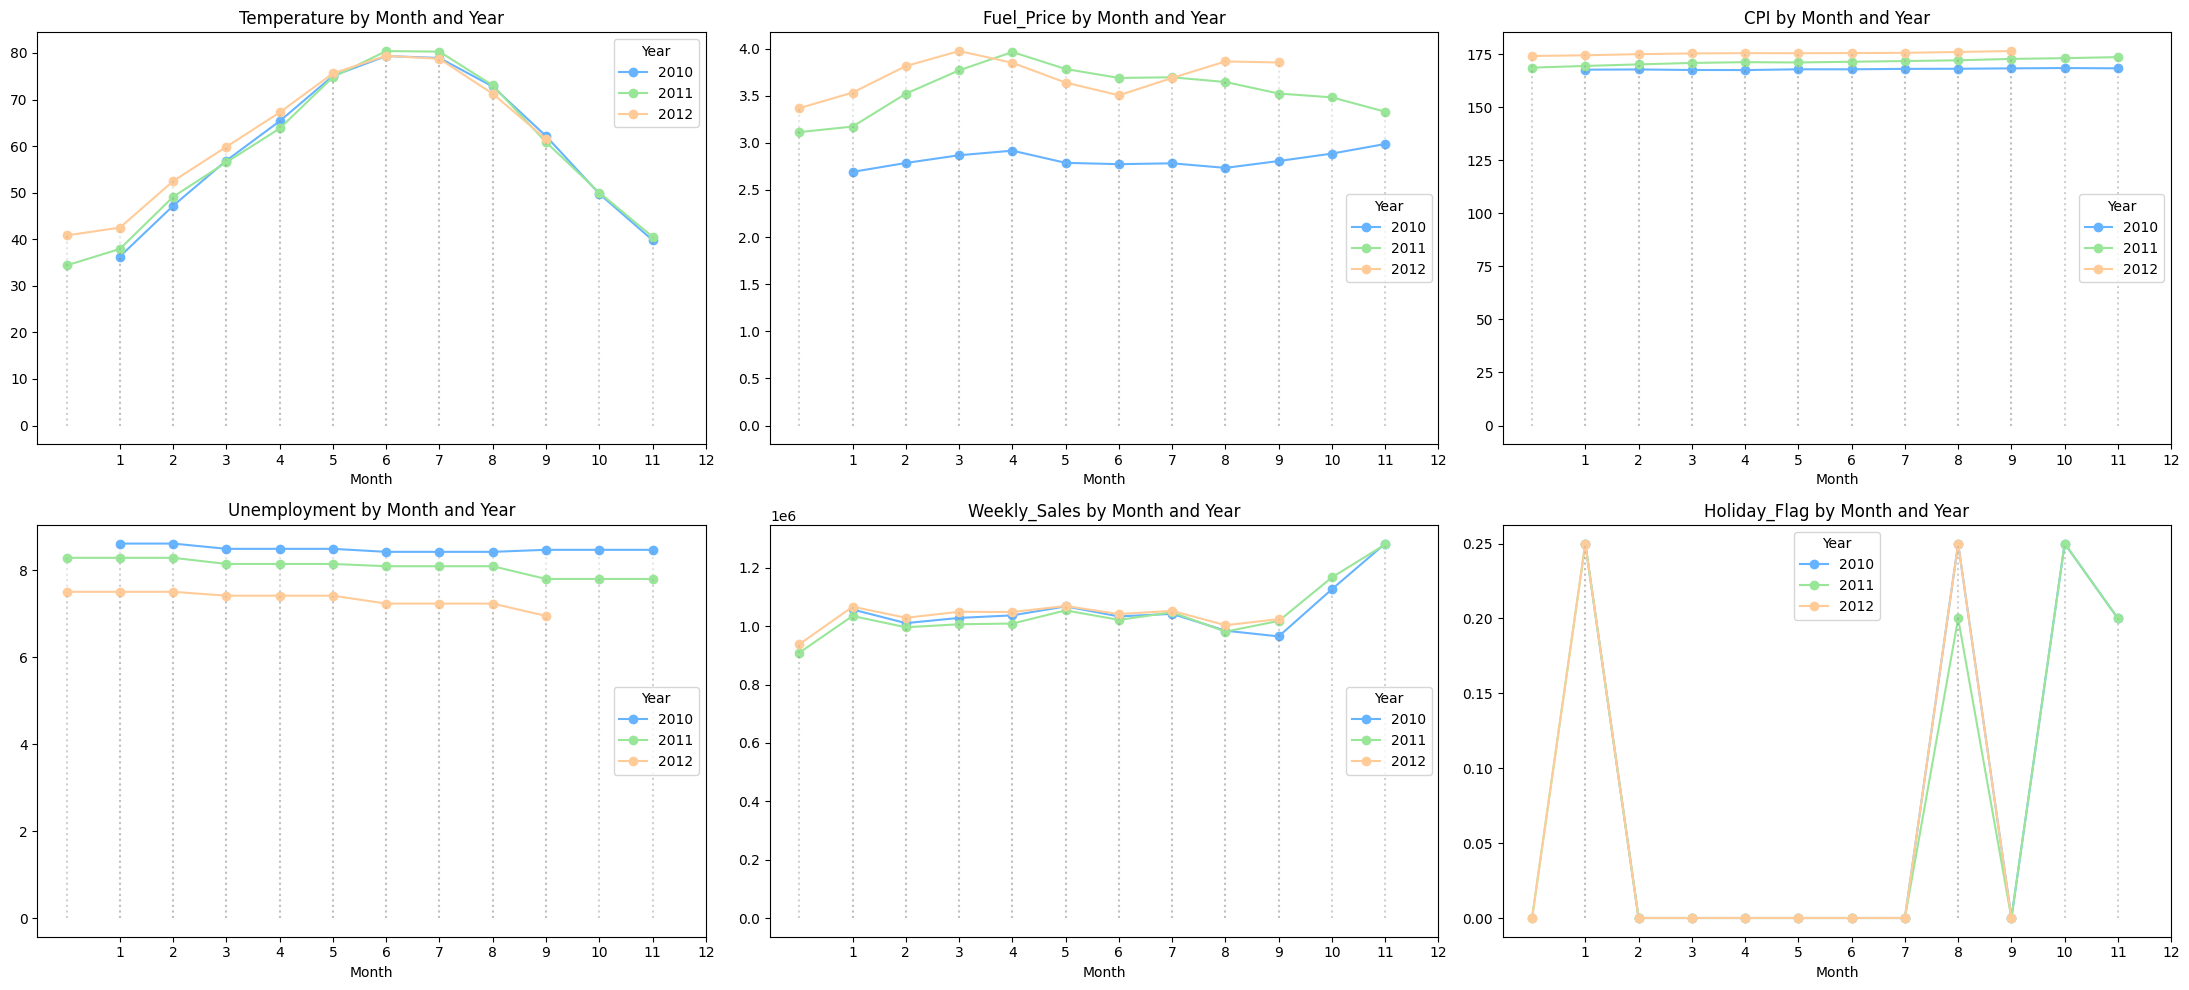

In [ ]:
# Define features to plot
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales', 'Holiday_Flag']

# Define a color palette
fixed_colors = ['#66b3ff', '#99e699', '#ffcc99']  # light blue, light green, light orange
year_list = sorted(df['Year'].unique())
year_color_map = {year: fixed_colors[i % len(fixed_colors)] for i, year in enumerate(year_list)}

# Setup subplots
fig, axs = plt.subplots(2, 3, figsize=(22, 10))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Create line plots with subtle vertical dotted lines
for i, feature in enumerate(features):
    ax = axs[i]

    for year in year_list:
        data_year = df[df['Year'] == year].groupby('Month')[feature].mean().reset_index()
        color = year_color_map[year]

        # Line with points
        ax.plot(data_year['Month'], data_year[feature], marker='o', color=color, label=str(year))

        # Subtle vertical dotted lines from x-axis
        for _, row in data_year.iterrows():
            ax.plot([row['Month'], row['Month']], [0, row[feature]], linestyle=':', color='gray', alpha=0.2)

    ax.set_title(f'{feature} by Month and Year')
    ax.set_xlabel('Month')
    ax.set_ylabel('')
    ax.set_xticks(np.arange(1, 13))
    ax.legend(title='Year', loc='best')

plt.tight_layout()
plt.show()


We are now able to see which categories can be encoded as one hot fields and which ones cannot.

To do this, let us check how many different values we have per different column

In [ ]:
# Counting unique values for each column
unique_counts = df.nunique()

print(unique_counts)

Store             45
Weekly_Sales    6435
Holiday_Flag       2
Temperature     3528
Fuel_Price       892
CPI             2145
Unemployment     349
Year               3
Month             12
Season             4
dtype: int64


In [ ]:
#Storing all unique months for each store
store_months = df.groupby('Store')['Month'].unique()

# Filtering stores that do not have all the twelve months
incomplete_stores = store_months[store_months.apply(lambda x: len(set(x)) < 12)]

print("Stores without all the twelve months of the year:")
print(len(incomplete_stores))


Stores without all the twelve months of the year:
0


Each store includes all months of the year and operates independently from the others. Therefore, a sensible approach is to split the dataset by store. Since we have 45 stores in total, to achieve a 70%-15%-15% split for training, validation, and testing respectively, we can allocate 31 stores for training, 7 for validation, and 7 for testing.

In [ ]:
lenght_training = df[df['Store'].between(1, 31)].shape[0]
lenght_validation = df[df['Store'].between(32, 38)].shape[0]
lenght_testing = df[df['Store'].between(39, 45)].shape[0]

print("training rows:", lenght_training)
print("validation rows:", lenght_validation)
print("testing rows:", lenght_testing)

training rows: 4433
validation rows: 1001
testing rows: 1001


Since 'Holiday_Flag' is already a binary variable, no further processing is needed. However, for 'Store', we should apply one-hot encoding, as its values are discrete and fall within a manageable range.

In [ ]:
onehot_fields = ['Year']

for field in onehot_fields:
   dummies = pd.get_dummies(df[field], prefix=field, drop_first=False)
   df = pd.concat([df, dummies], axis=1)

dopping_columns = ['Store']
df = df.drop(dopping_columns, axis=1)
df = df.drop(onehot_fields, axis = 1)
df.head()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Season,Year_2010,Year_2011,Year_2012
0,1643690.90,0,42.31,2.572,211.096358,8.106,1,0,True,False,False
1,1641957.44,1,38.51,2.548,211.242170,8.106,1,0,True,False,False
2,1611968.17,0,39.93,2.514,211.289143,8.106,1,0,True,False,False
3,1409727.59,0,46.63,2.561,211.319643,8.106,1,0,True,False,False
4,1554806.68,0,46.50,2.625,211.350143,8.106,2,1,True,False,False


We can now normalize the remaining continous columns



In [ ]:
continuous_fields = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

scaled_features = {}
for field in continuous_fields:
    mean = df[field].mean()
    std = df[field].std()
    scaled_features[field] = [mean, std]
    df.loc[:, field] = (df[field] - mean)/std

df.head()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Season,Year_2010,Year_2011,Year_2012
0,1.057338,0,-0.995058,-1.713667,1.004097,0.056959,1,0,True,False,False
1,1.054266,1,-1.201077,-1.765952,1.007802,0.056959,1,0,True,False,False
2,1.001128,0,-1.124091,-1.840023,1.008996,0.056959,1,0,True,False,False
3,0.642778,0,-0.760848,-1.737631,1.009771,0.056959,1,0,True,False,False
4,0.899844,0,-0.767896,-1.598203,1.010546,0.056959,2,1,True,False,False


After the encoding, the table has columns:

In [ ]:
df.columns

Index(['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Month', 'Season', 'Year_2010', 'Year_2011',
       'Year_2012'],
      dtype='object')

Dividing the dataset into training, testing and validation sets

In [ ]:
# 31 sore training
train = df[-lenght_training:]
df = df[:-lenght_training]

# 7 stores validation
val = df[-lenght_validation:]
df = df[:-lenght_validation]

# The remaining (earlier) data will be used for training
test = df

print("Train data length:", len(train))
print("Validation data length:", len(val))
print("Test data length:", len(test))

Train data length: 4433
Validation data length: 1001
Test data length: 1001


In [ ]:
val.head()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Season,Year_2010,Year_2011,Year_2012
1001,-0.075886,0,-1.437998,-1.713667,1.089854,-0.90632,1,0,True,False,False
1002,-0.092428,1,-1.481371,-1.765952,1.093664,-0.90632,1,0,True,False,False
1003,-0.147076,0,-1.169090,-1.840023,1.094809,-0.90632,1,0,True,False,False
1004,-0.353268,0,-1.233606,-1.737631,1.095510,-0.90632,1,0,True,False,False
1005,-0.293180,0,-0.814521,-1.598203,1.096211,-0.90632,2,1,True,False,False


Let us define the target fields.

Because we need to work with two different fields (season and month) it might be helpful to see the results of the prediction through different graphs

In [ ]:
columns_to_drop = ['Month', 'Season']

target_month = 'Month'

X_train= train.drop(columns_to_drop, axis=1)
X_test = test.drop(columns_to_drop, axis=1)
X_val= val.drop(columns_to_drop, axis=1)

Y_train_month = train[target_month]
Y_test_month = test[target_month]
Y_val_month = val[target_month]

print("MONTH")

print("Train features shape : ", X_train.shape)
print("Train targets shape: ", Y_train_month.shape)

print("Validation features shape: ", X_test.shape)
print("Validation targets shape: ", Y_test_month.shape)

print("Test features shape: ", X_val.shape)
print("Test targets shape: ", Y_val_month.shape)


MONTH
Train features shape :  (4433, 9)
Train targets shape:  (4433,)
Validation features shape:  (1001, 9)
Validation targets shape:  (1001,)
Test features shape:  (1001, 9)
Test targets shape:  (1001,)


In [ ]:
target_season = 'Season'

Y_train_season = train[target_season]
Y_test_season = test[target_season]
Y_val_season = val[target_season]

print("SEASON")

print("Train features shape : ", X_train.shape)
print("Train targets shape: ", Y_train_season.shape)

print("Validation features shape: ", X_test.shape)
print("Validation targets shape: ", Y_test_season.shape)

print("Test features shape: ", X_val.shape)
print("Test targets shape: ", Y_val_season.shape)

SEASON
Train features shape :  (4433, 9)
Train targets shape:  (4433,)
Validation features shape:  (1001, 9)
Validation targets shape:  (1001,)
Test features shape:  (1001, 9)
Test targets shape:  (1001,)


In [ ]:
Y_test_month.head()

,Month
0,1
1,1
2,1
3,1
4,2


## Defining SVMs with different parameters

*Month* and *Season* fields have similar relations with the features, so it could be possible to define a general model to use in both cases.
But in order to make the comparison more visible we will use models with different names but same characteristics.

C = 1

In [ ]:
model_month = SVC(kernel='rbf', C=1, gamma='scale')
model_month.fit(X_train, Y_train_month)

Y_pred_month = model_month.predict(X_val)

accuracy_month = accuracy_score(Y_val_month, Y_pred_month)
print(f'Accuracy on validation set for Month prediction: {accuracy_month:.2f}')

Accuracy on validation set for Month prediction: 0.41


C = 10 and setting gamma

In [ ]:
model_month = SVC(kernel='rbf', C=10, gamma = 0.1)
model_month.fit(X_train, Y_train_month)

Y_pred_month = model_month.predict(X_val)

accuracy_month = accuracy_score(Y_val_month, Y_pred_month)
print(f'Accuracy on validation set for Month prediction: {accuracy_month:.2f}')

Accuracy on validation set for Month prediction: 0.46


C = 100 with same gamma

In [ ]:
model_month = SVC(kernel='rbf', C=100, gamma = 0.1)
model_month.fit(X_train, Y_train_month)

Y_pred_month = model_month.predict(X_val)

accuracy_month = accuracy_score(Y_val_month, Y_pred_month)
print(f'Accuracy on validation set for Month prediction: {accuracy_month:.2f}')

Accuracy on validation set for Month prediction: 0.43


C = 1000 with smaller gamma

In [ ]:
model_month = SVC(kernel='rbf', C=1000, gamma = 0.01)
model_month.fit(X_train, Y_train_month)

Y_pred_month = model_month.predict(X_val)

accuracy_month = accuracy_score(Y_val_month, Y_pred_month)
print(f'Accuracy on validation set for Month prediction: {accuracy_month:.2f}')

Accuracy on validation set for Month prediction: 0.49


Balancing the different classes

In [ ]:
model_month = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.01) #1 1E6 1,000,000
model_month.fit(X_train, Y_train_month)

Y_pred_month = model_month.predict(X_val)

accuracy_month = accuracy_score(Y_val_month, Y_pred_month)
print(f'Accuracy on validation set for Month prediction: {accuracy_month:.2f}')

Accuracy on validation set for Month prediction: 0.49


Working with Season

C = 1

In [ ]:
model_season = SVC(kernel='rbf', C=1, gamma = 'scale')
model_season.fit(X_train, Y_train_season)

Y_pred_season = model_season.predict(X_val)

accuracy_season = accuracy_score(Y_val_season, Y_pred_season)
print(f'Accuracy on validation set for Season prediction: {accuracy_season:.2f}')

Accuracy on validation set for Season prediction: 0.66


C = 10 and setting gamma

In [ ]:
model_season = SVC(kernel='rbf', C=10, gamma = 0.1)
model_season.fit(X_train, Y_train_season)

Y_pred_season = model_season.predict(X_val)

accuracy_season = accuracy_score(Y_val_season, Y_pred_season)
print(f'Accuracy on validation set for Season prediction: {accuracy_season:.2f}')

Accuracy on validation set for Season prediction: 0.65


C = 100 and setting smaller gamma



In [ ]:
model_season = SVC(kernel='rbf', C=100, gamma = 0.01)
model_season.fit(X_train, Y_train_season)

Y_pred_season = model_season.predict(X_val)

accuracy_season = accuracy_score(Y_val_season, Y_pred_season)
print(f'Accuracy on validation set for Season prediction: {accuracy_season:.2f}')

Accuracy on validation set for Season prediction: 0.68


C = 1000

In [ ]:
model_season = SVC(kernel='rbf', C=1000, gamma = 0.01)
model_season.fit(X_train, Y_train_season)

Y_pred_season = model_season.predict(X_val)

accuracy_season = accuracy_score(Y_val_season, Y_pred_season)
print(f'Accuracy on validation set for Season prediction: {accuracy_season:.2f}')

Accuracy on validation set for Season prediction: 0.68


Balancing the different classes

In [ ]:
model_season = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.01)
model_season.fit(X_train, Y_train_season)

Y_pred_season = model_season.predict(X_val)

accuracy_season = accuracy_score(Y_val_season, Y_pred_season)
print(f'Accuracy on validation set for Season prediction: {accuracy_season:.2f}')

Accuracy on validation set for Season prediction: 0.69


## Show results and comparing the different outputs

Graphically representing the month prediction:

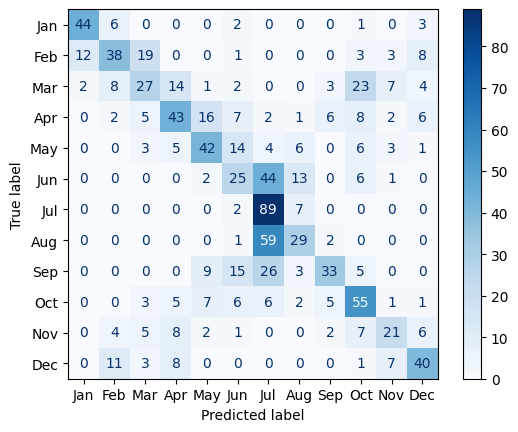

In [ ]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Y_val_month_mapped = Y_val_month
Y_pred_month_mapped = Y_pred_month

# Generate the confusion matrix
cm = confusion_matrix(Y_val_month_mapped, Y_pred_month_mapped)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

# Set the ticks and labels on the X axis
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)

plt.show()

In graphically representing the season prediction:

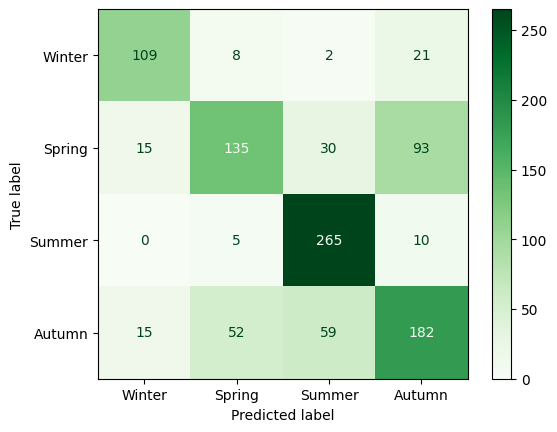

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ['Winter', 'Spring', 'Summer', 'Autumn']

Y_val_season_mapped = Y_val_season
Y_pred_season_mapped = Y_pred_season

# Generate the confusion matrix
cm = confusion_matrix(Y_val_season_mapped, Y_pred_season_mapped, labels=range(4))

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens')

# Set the ticks and labels on the X axis
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)

plt.show()

Testing with both targets:

In [ ]:
Y_pred_month_test = model_month.predict(X_test)

accuracy_month_test = accuracy_score(Y_test_month, Y_pred_month_test)
print(f'Accuracy on test set for Month prediction: {accuracy_month_test:.2f}')

Accuracy on test set for Month prediction: 0.50


In [ ]:
Y_pred_season_test = model_season.predict(X_test)

accuracy_season_test = accuracy_score(Y_test_season, Y_pred_season_test)
print(f'Accuracy on test set for Season prediction: {accuracy_season_test:.2f}')

Accuracy on test set for Season prediction: 0.69


Checking which classes were the most important

In [ ]:
result = permutation_importance(model_month, X_val, Y_val_month, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(feature_importance.head(40))

        Feature  Importance
2   Temperature    0.280220
3    Fuel_Price    0.269031
4           CPI    0.144855
6     Year_2010    0.135365
8     Year_2012    0.127273
5  Unemployment    0.099301
7     Year_2011    0.077123
1  Holiday_Flag    0.044256
0  Weekly_Sales    0.006893
